<!-- # Analysis and Design of Multi-Layer Neural Networks (MLP)

## Table of Contents
- [MLP Design](#mlp-design)
- [Train Two Different Models](#train-two-different-models)
- [Back Propagation Algorithm](#back-propagation-algorithm)
- [Analysis of Different Hyperparameters](#analysis-of-different-hyperparameters)
- [References](#references) -->

## Import Libraries

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

## Utils

In [92]:
def plot_weight_histogram(model, layer_name, title='Weight Histogram'):
    plt.figure(figsize=(5, 3))
    weights = getattr(model, layer_name).weight.detach().cpu().numpy().flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

def sub_plot(epochs, data, p_label, title, y_label):
    plt.plot(epochs, data, 'bo-', label=p_label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()

def plot_train_results(m):
    train_losses = m.train_losses
    train_accuracies = m.train_accuracies
    num_epochs = len(train_losses)
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    sub_plot(epochs, train_losses, 'Training Loss', title='Training Loss', y_label='Loss')

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    sub_plot(epochs, train_accuracies, 'Training Accuracy', title='Training Accuracy', y_label='Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    return cm

def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def format(accuracy): 
    return f"{accuracy:.3f}"

def plot_curve(results, what, label, y_label, title):
    for metric, history in results.items():
        data = history[what]
        plt.plot(data, label=label+f'{metric})')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()



In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(42)
torch.manual_seed(42)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cuda


In [94]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

one issue was I tried to set the transformer this lambda bellow and the test loss was unbelievable!

## Dataset

In [95]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

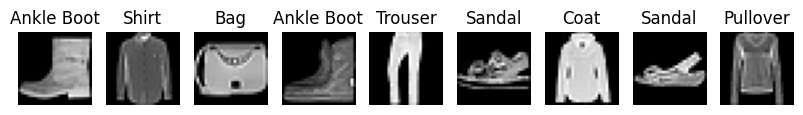

In [96]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 9,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## MLP Design

In [7]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [8]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate)
        for _ in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)

    def fit(self, train_loader, test_loader, num_epochs):
        for _ in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)


In [9]:
m = MLP(Model(100, do_rate=0.3), nn.CrossEntropyLoss())

In [10]:
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = m.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/30], Train Loss: 1.7489, Train Acc: 0.4804
Epoch [2/30], Train Loss: 1.1242, Train Acc: 0.6581
Epoch [3/30], Train Loss: 0.9182, Train Acc: 0.6996
Epoch [4/30], Train Loss: 0.8243, Train Acc: 0.7202
Epoch [5/30], Train Loss: 0.7681, Train Acc: 0.7355
Epoch [6/30], Train Loss: 0.7261, Train Acc: 0.7469
Epoch [7/30], Train Loss: 0.7010, Train Acc: 0.7543
Epoch [8/30], Train Loss: 0.6776, Train Acc: 0.7619
Epoch [9/30], Train Loss: 0.6578, Train Acc: 0.7679
Epoch [10/30], Train Loss: 0.6417, Train Acc: 0.7742
Epoch [11/30], Train Loss: 0.6281, Train Acc: 0.7794
Epoch [12/30], Train Loss: 0.6180, Train Acc: 0.7829
Epoch [13/30], Train Loss: 0.6017, Train Acc: 0.7886
Epoch [14/30], Train Loss: 0.5916, Train Acc: 0.7945
Epoch [15/30], Train Loss: 0.5826, Train Acc: 0.7947
Epoch [16/30], Train Loss: 0.5752, Train Acc: 0.7975
Epoch [17/30], Train Loss: 0.5669, Train Acc: 0.8005
Epoch [18/30], Train Loss: 0.5641, Train Acc: 0.8021
Epoch [19/30], Train Loss: 0.5561, Train Acc: 0.8062
Ep

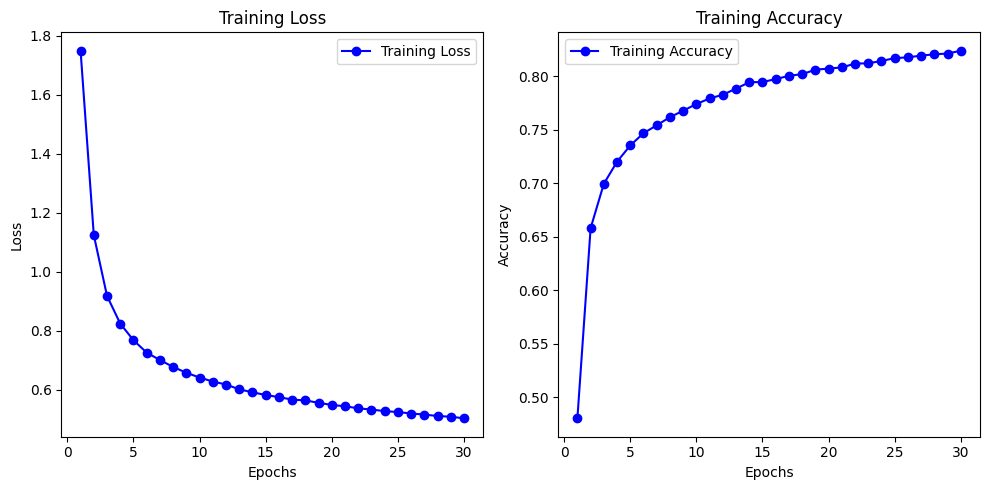

In [11]:
plot_train_results(m)

In [12]:
_, _ = m.evaluate(train_loader)
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.80      6000
     Trouser       0.97      0.95      0.96      6000
    Pullover       0.74      0.73      0.74      6000
       Dress       0.84      0.87      0.85      6000
        Coat       0.73      0.79      0.76      6000
      Sandal       0.91      0.91      0.91      6000
       Shirt       0.63      0.54      0.58      6000
     Sneaker       0.89      0.88      0.89      6000
         Bag       0.94      0.94      0.94      6000
  Ankle boot       0.91      0.93      0.92      6000

    accuracy                           0.84     60000
   macro avg       0.83      0.84      0.84     60000
weighted avg       0.83      0.84      0.84     60000



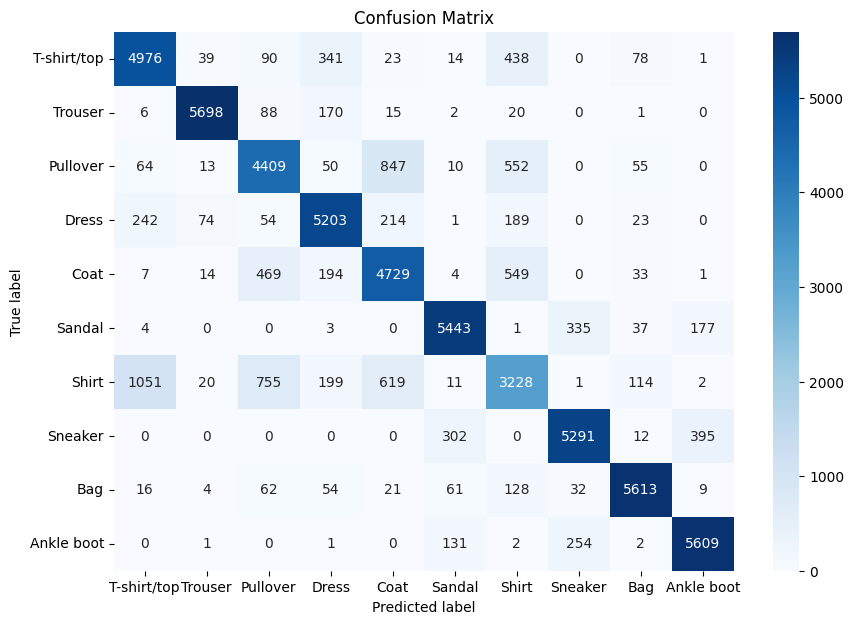

In [13]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [14]:
test_loss, _ = m.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4913
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.98      0.94      0.96      1000
    Pullover       0.72      0.71      0.71      1000
       Dress       0.81      0.85      0.83      1000
        Coat       0.71      0.76      0.73      1000
      Sandal       0.91      0.89      0.90      1000
       Shirt       0.57      0.51      0.54      1000
     Sneaker       0.88      0.88      0.88      1000
         Bag       0.93      0.94      0.93      1000
  Ankle boot       0.89      0.93      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



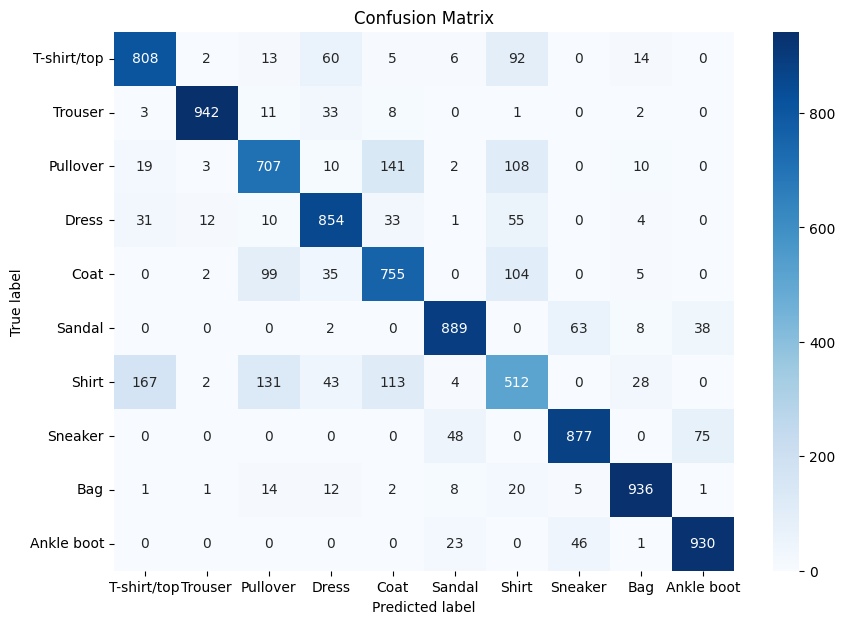

In [15]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [16]:
most_confused = {}
for i in range(10):
    row = cm[i]
    row[i] = 0
    most_confused_class = np.argmax(row)
    most_confused[i] = most_confused_class

for m in range(10):
    print(f"Class `{class_names[m]}` is most often confused with class `{class_names[most_confused[m]]}`")

Class `T-shirt/top` is most often confused with class `Shirt`
Class `Trouser` is most often confused with class `Dress`
Class `Pullover` is most often confused with class `Coat`
Class `Dress` is most often confused with class `Shirt`
Class `Coat` is most often confused with class `Shirt`
Class `Sandal` is most often confused with class `Sneaker`
Class `Shirt` is most often confused with class `T-shirt/top`
Class `Sneaker` is most often confused with class `Ankle boot`
Class `Bag` is most often confused with class `Shirt`
Class `Ankle boot` is most often confused with class `Sneaker`


In [17]:
conf_matrix_copy = cm.copy()
np.fill_diagonal(conf_matrix_copy, 0)  # Zero the diagonal

most_common_confusion = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)

# Print the most commonly confused classes
print(f"The two most commonly confused classes are: `{class_names[most_common_confusion[0]]}` with `{class_names[most_common_confusion[1]]}`.")


The two most commonly confused classes are: `Shirt` with `T-shirt/top`.


#### Impact of Increasing Model Complexity

#### Criteria for Choosing the Best Configuration

- **Validation performance** : Monitor the validation accuracy and loss to ensure the model generalizes well.
- **Training stability** : Ensure that the model does not exhibit overfitting (training accuracy much higher than validation accuracy) or underfitting (both training and validation accuracies are low).
- **Computational efficiency** : Balance model complexity with computational resources (training time, memory usage).
- **Regularization** : Ensure proper regularization (e.g., dropout, L2 regularization) to prevent overfitting.

We can tune hyperparameters such as the number of layers, number of neurons per layer, regularization techniques, and learning rate to find the best configuration.

## Train Two Different Models

In [18]:
cirteria = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [19]:
model1 = Model(128)
model1.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)>

In [20]:
model2 = Model(48, 0.2)
model2.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=48, out_features=10, bias=True)
)>

In [21]:
m1 = MLP(model1, cirteria)
m2 = MLP(model2, cirteria, lambda_reg=0.0001)

In [22]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m1.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.3925, Train Acc: 0.6136
Epoch [2/40], Train Loss: 0.7891, Train Acc: 0.7448
Epoch [3/40], Train Loss: 0.6688, Train Acc: 0.7691
Epoch [4/40], Train Loss: 0.6123, Train Acc: 0.7855
Epoch [5/40], Train Loss: 0.5761, Train Acc: 0.7985
Epoch [6/40], Train Loss: 0.5502, Train Acc: 0.8078
Epoch [7/40], Train Loss: 0.5305, Train Acc: 0.8157
Epoch [8/40], Train Loss: 0.5151, Train Acc: 0.8202
Epoch [9/40], Train Loss: 0.5024, Train Acc: 0.8250
Epoch [10/40], Train Loss: 0.4918, Train Acc: 0.8283
Epoch [11/40], Train Loss: 0.4829, Train Acc: 0.8317
Epoch [12/40], Train Loss: 0.4749, Train Acc: 0.8338
Epoch [13/40], Train Loss: 0.4679, Train Acc: 0.8367
Epoch [14/40], Train Loss: 0.4617, Train Acc: 0.8388
Epoch [15/40], Train Loss: 0.4561, Train Acc: 0.8411
Epoch [16/40], Train Loss: 0.4510, Train Acc: 0.8424
Epoch [17/40], Train Loss: 0.4462, Train Acc: 0.8438
Epoch [18/40], Train Loss: 0.4418, Train Acc: 0.8458
Epoch [19/40], Train Loss: 0.4376, Train Acc: 0.8468
Ep

In [23]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m2.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.4550, Train Acc: 0.5552
Epoch [2/40], Train Loss: 0.9047, Train Acc: 0.6999
Epoch [3/40], Train Loss: 0.7796, Train Acc: 0.7318
Epoch [4/40], Train Loss: 0.7143, Train Acc: 0.7498
Epoch [5/40], Train Loss: 0.6731, Train Acc: 0.7654
Epoch [6/40], Train Loss: 0.6445, Train Acc: 0.7765
Epoch [7/40], Train Loss: 0.6176, Train Acc: 0.7847
Epoch [8/40], Train Loss: 0.5986, Train Acc: 0.7919
Epoch [9/40], Train Loss: 0.5830, Train Acc: 0.7972
Epoch [10/40], Train Loss: 0.5657, Train Acc: 0.8024
Epoch [11/40], Train Loss: 0.5550, Train Acc: 0.8082
Epoch [12/40], Train Loss: 0.5457, Train Acc: 0.8105
Epoch [13/40], Train Loss: 0.5373, Train Acc: 0.8146
Epoch [14/40], Train Loss: 0.5294, Train Acc: 0.8172
Epoch [15/40], Train Loss: 0.5206, Train Acc: 0.8198
Epoch [16/40], Train Loss: 0.5160, Train Acc: 0.8211
Epoch [17/40], Train Loss: 0.5081, Train Acc: 0.8243
Epoch [18/40], Train Loss: 0.5027, Train Acc: 0.8260
Epoch [19/40], Train Loss: 0.4977, Train Acc: 0.8279
Ep

In [24]:
test_loss, _ = m1.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4237
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.84      0.82      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.73      0.78      0.75      1000
       Dress       0.85      0.87      0.86      1000
        Coat       0.74      0.77      0.76      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.67      0.55      0.61      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.94      0.95      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [25]:
test_loss, _ = m2.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4320
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.75      0.73      0.74      1000
       Dress       0.84      0.87      0.85      1000
        Coat       0.73      0.78      0.75      1000
      Sandal       0.93      0.91      0.92      1000
       Shirt       0.65      0.58      0.61      1000
     Sneaker       0.90      0.91      0.91      1000
         Bag       0.94      0.95      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [26]:
weights = getattr(m1.model, 'out').weight.detach().cpu().numpy().flatten()

Model 1 Weight Histograms (128 Neurons, No Dropout)


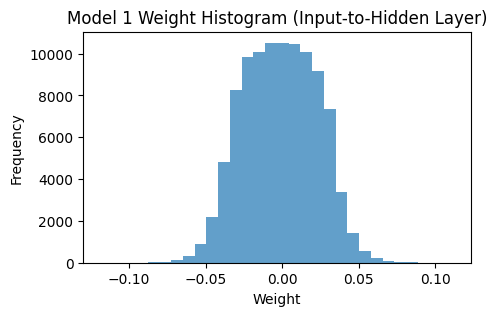

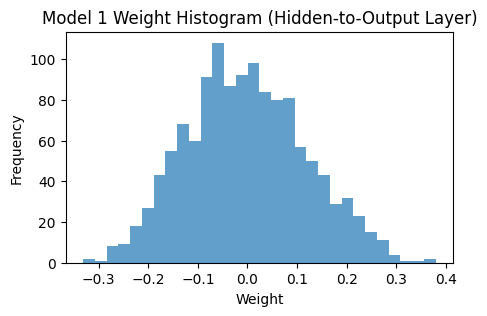

In [27]:
print("Model 1 Weight Histograms (128 Neurons, No Dropout)")
plot_weight_histogram(m1.model, 'fc1', 'Model 1 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m1.model, 'out', 'Model 1 Weight Histogram (Hidden-to-Output Layer)')

Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)


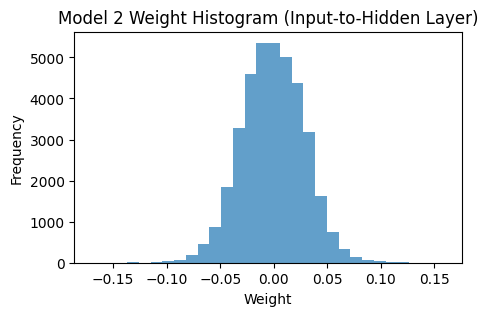

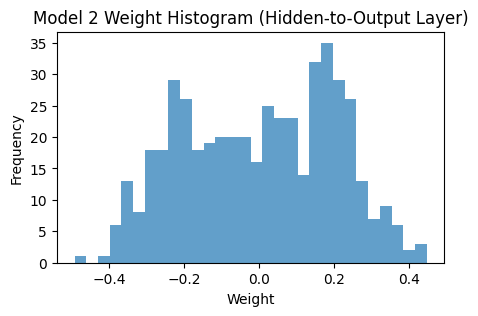

In [28]:
print("Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)")
plot_weight_histogram(m2.model, 'fc1', 'Model 2 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m2.model, 'out', 'Model 2 Weight Histogram (Hidden-to-Output Layer)')

In [29]:
# Evaluate models on test data
test_loss1, test_acc1 = m1.evaluate(test_loader)
test_loss2, test_acc2 = m2.evaluate(test_loader)

print(f"Model 1 Test Accuracy: {test_acc1:.4f}")
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")


Model 1 Test Accuracy: 0.8481
Model 2 Test Accuracy: 0.8448


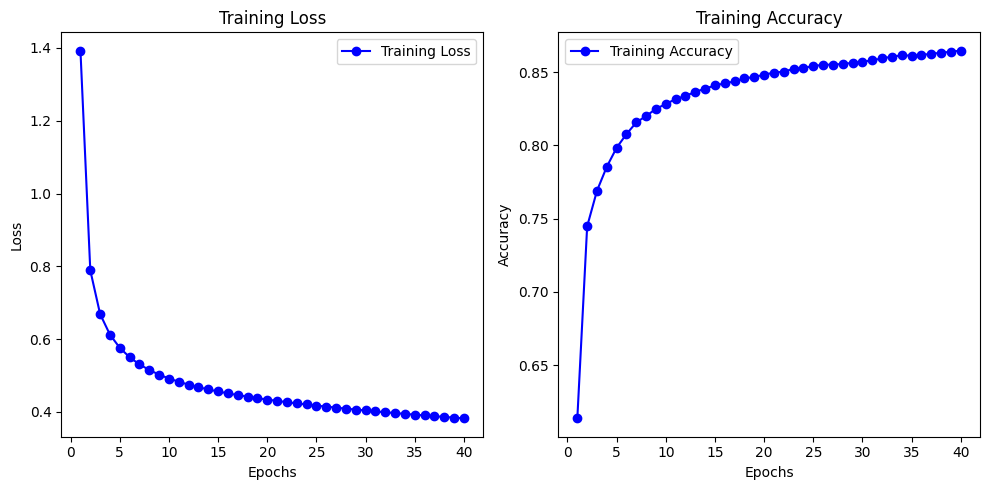

In [71]:
plot_train_results(m1)

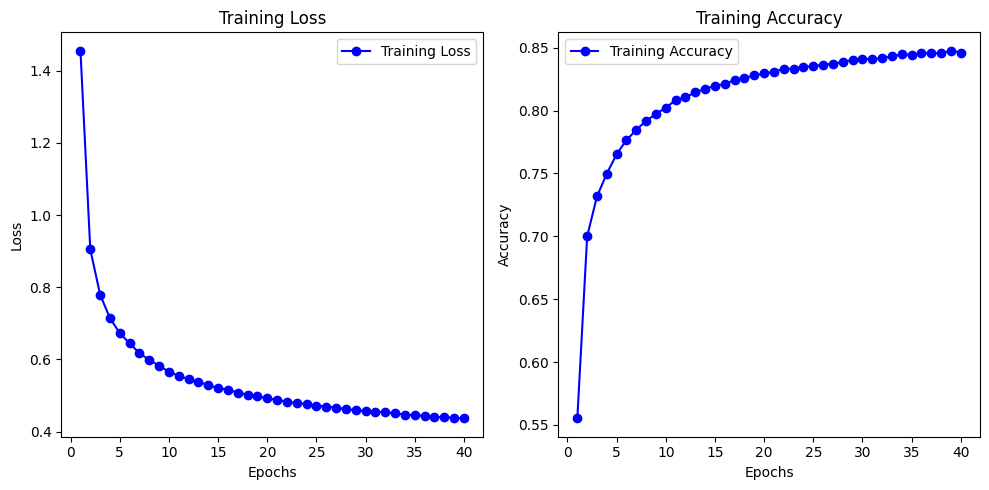

In [72]:
plot_train_results(m2)

## Back Propagation Algorithm

In [30]:
optimizers = { 
    'Adam': optim.Adam, 
    'NAdam': optim.NAdam, 
    'RMSprop': optim.RMSprop
}
table = []
results = {}
h1 = 100
do_rate = 0.2

Test Result for Adam Optmizer
Test Loss: 0.3626
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.81      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.78      0.81      0.79      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.80      0.82      0.81      1000
      Sandal       0.98      0.95      0.96      1000
       Shirt       0.69      0.65      0.67      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test Result for NAdam Optmizer
Test Loss: 0.3546
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.88      0.83      1000
     Trouser       0.98      0.97  

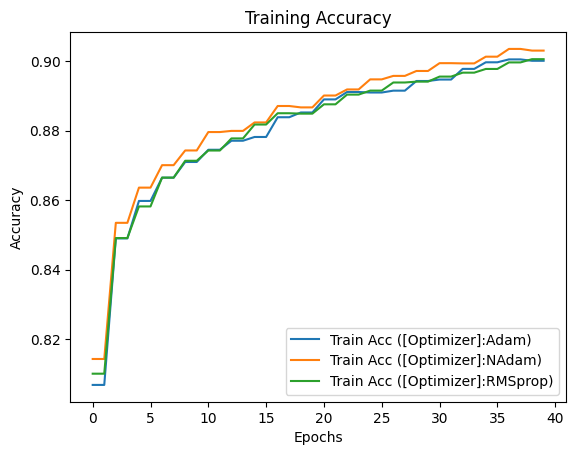

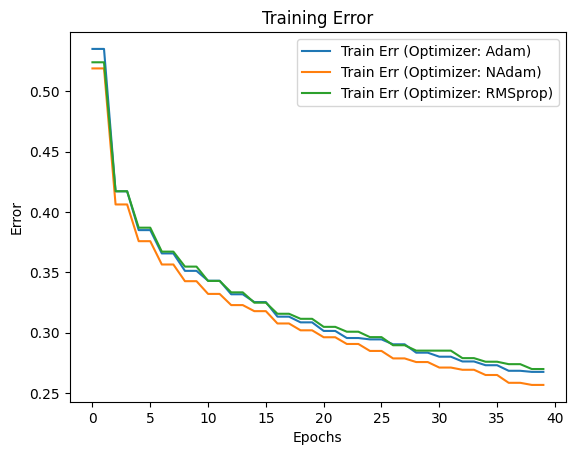

+--------------------+----------+-------+
| Optimizer Analysis | Accuracy | Loss  |
+--------------------+----------+-------+
|     Train-Adam     |  0.900   | 0.267 |
|     Test-Adam      |  0.878   | 0.363 |
|    Train-NAdam     |  0.903   | 0.257 |
|     Test-NAdam     |  0.880   | 0.355 |
|   Train-RMSprop    |  0.901   | 0.270 |
|    Test-RMSprop    |  0.875   | 0.402 |
+--------------------+----------+-------+


In [31]:
test_loss, test_acc = 0, 0
for name, optimizer in optimizers.items():
    mlp = MLP(Model(h1, do_rate=do_rate), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.compile(optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=20)    
    table += [
        [f'Train-{name}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{name}', format(test_acc), format(test_loss)]
    ]
    results[name] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }
    print(f"Test Result for {name} Optmizer")
    print(f"Test Loss: {test_loss:.4f}")
    print(classification_report(mlp.all_labels, mlp.all_preds, target_names=class_names, zero_division=0))

plot_curve(results, 'train_accuracy', 
            label=f'Train Acc ([Optimizer]:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (Optimizer: ', 
            y_label='Error', title='Training Error')

print(tabulate(table, headers=["Optimizer Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

## Analysis of Different Hyperparameters

In [97]:
def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def format(accuracy): 
    return f"{accuracy:.3f}"

def plot_curve(results, what, label, y_label, title):
    for metric, history in results.items():
        data = history[what]
        plt.plot(data, label=label+f'{metric})')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

In [98]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [117]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate) # optim.SGD(self.model.parameters(), lr=self.learning_rate)
        train_hist, test_hist = [], []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            train_hist.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc})

        test_loss, test_acc = self.evaluate(test_loader)
        test_hist.append({"test_loss": test_loss, "test_acc": test_acc})
        return train_hist, test_hist
    
    def train(self, x_train, y_train):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in enumerate(zip(x_train, y_train)):
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(y_train.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def fit(self, x_train, y_train, num_epochs=10):
        for _ in range(x_train, y_train, num_epochs):
            _, _ = self.train(train_loader)

        return self.evaluate(test_loader)

    def fit(self, train_loader, test_loader, num_epochs=10):
        for _ in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "criteria": self.criteria,
            "lambda_reg": self.lambda_reg,
            "learning_rate": self.learning_rate
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [118]:
dropout_rates = [0.2, 0.4, 0.8]
learning_rates = [0.001, 0.01, 0.1]
lambda_regs = [0.0001, 0.001, 0.01]
hidden_layer_neuron_counts = [32, 64, 128]


#### Dropout Rate Analysis

confusion_matrix for dropout rate: 0.2


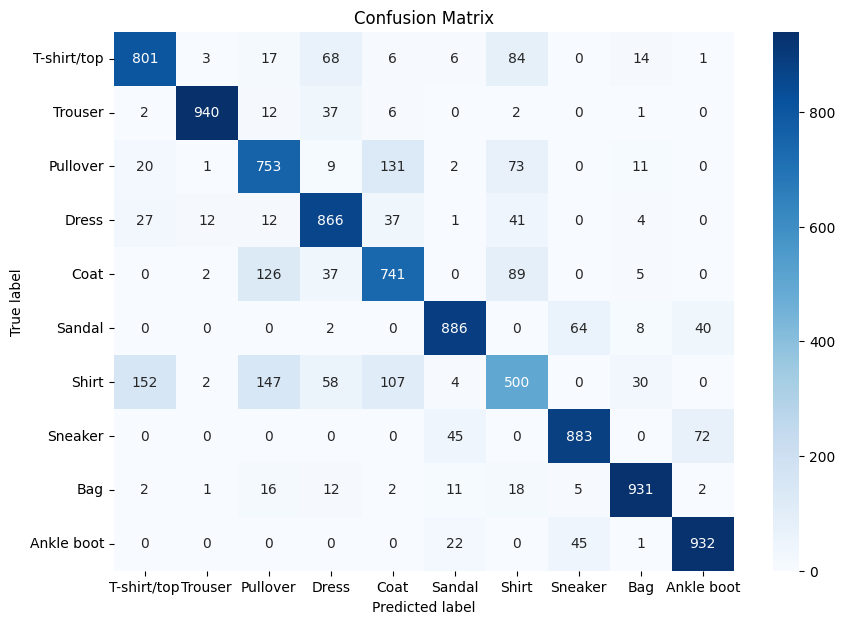

confusion_matrix for dropout rate: 0.4


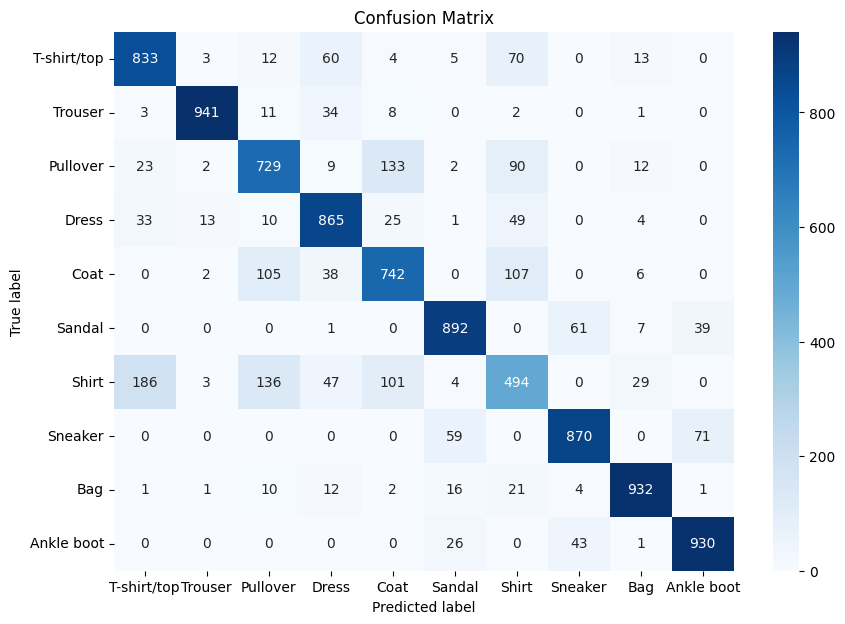

confusion_matrix for dropout rate: 0.8


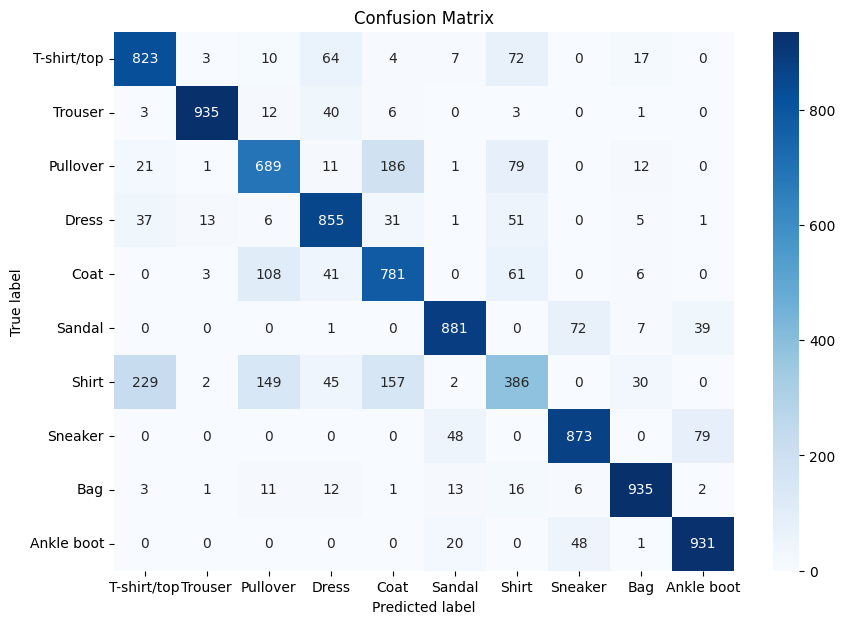

In [61]:
h1= 128
results = {}
table = []

test_loss, test_acc = 0, 0
for do_rate in dropout_rates:
    mlp = MLP(Model(h1, do_rate=do_rate), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=15)
    table += [
        [f'Train-{do_rate}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{do_rate}', format(test_acc), format(test_loss)]
    ]
    results[do_rate] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }
    print('confusion_matrix for dropout rate:', do_rate)
    cm = plot_confusion_matrix(mlp.all_labels, mlp.all_preds, class_names)

In [62]:
print(tabulate(table, headers=["Dropout Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+------------------+----------+-------+
| Dropout Analysis | Accuracy | Loss  |
+------------------+----------+-------+
|    Train-0.2     |  0.828   | 0.487 |
|     Test-0.2     |  0.823   | 0.489 |
|    Train-0.4     |  0.822   | 0.510 |
|     Test-0.4     |  0.823   | 0.491 |
|    Train-0.8     |  0.761   | 0.693 |
|     Test-0.8     |  0.809   | 0.533 |
+------------------+----------+-------+


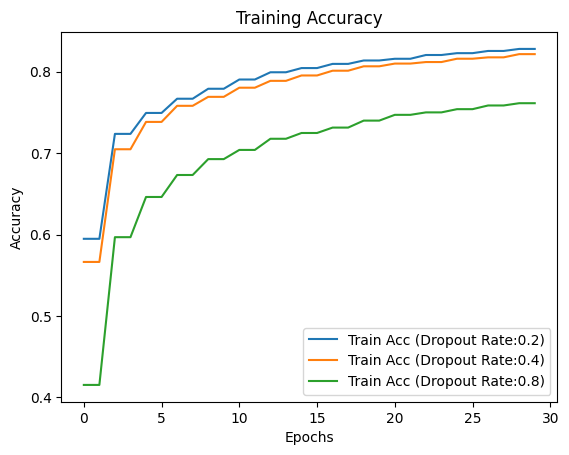

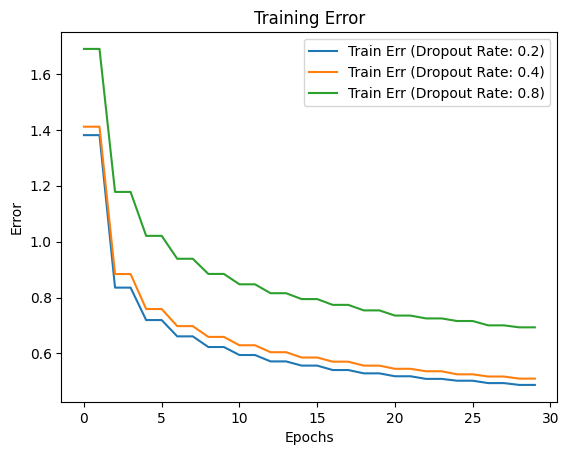

In [63]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (Dropout Rate:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (Dropout Rate: ', 
            y_label='Error', title='Training Error')

#### Neuron Count Analysis

confusion_matrix for neuron count: 32


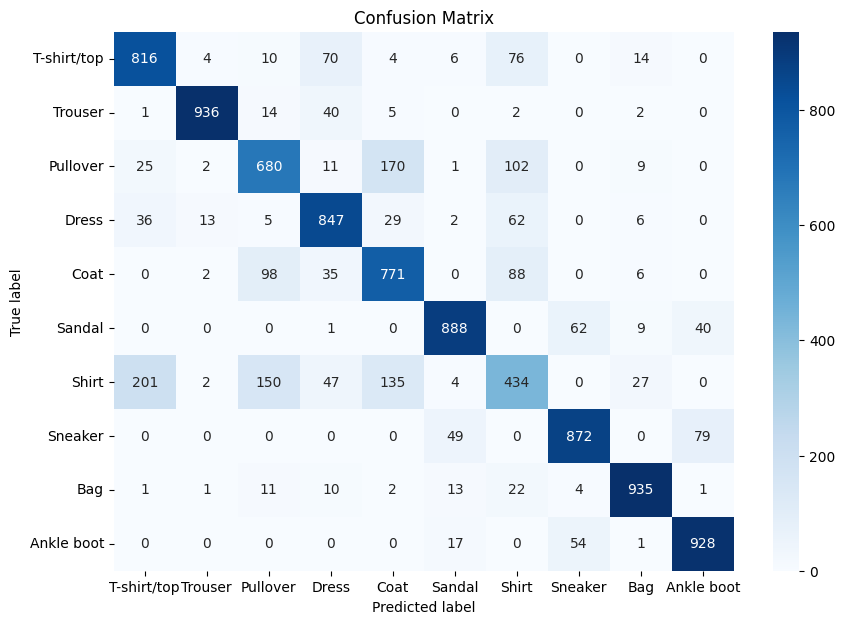

confusion_matrix for neuron count: 64


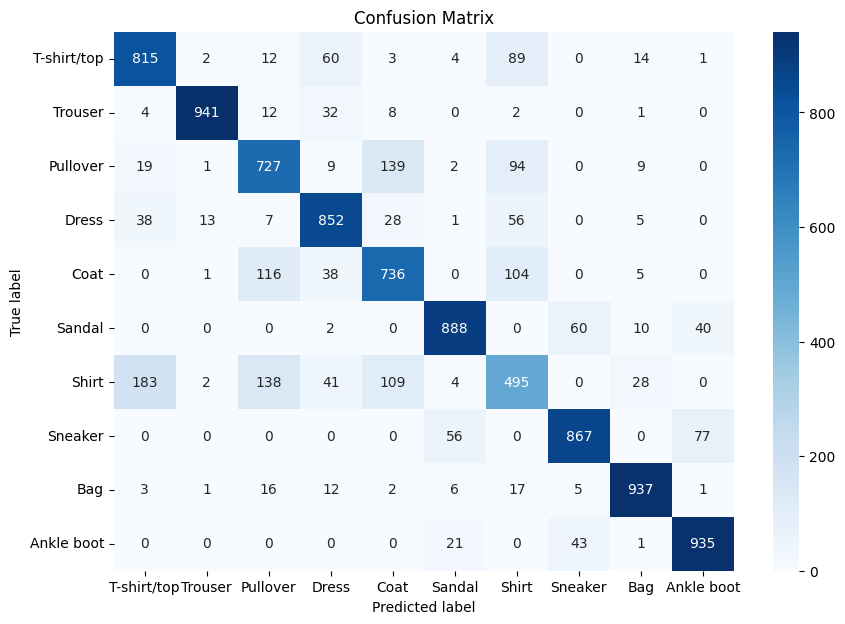

confusion_matrix for neuron count: 128


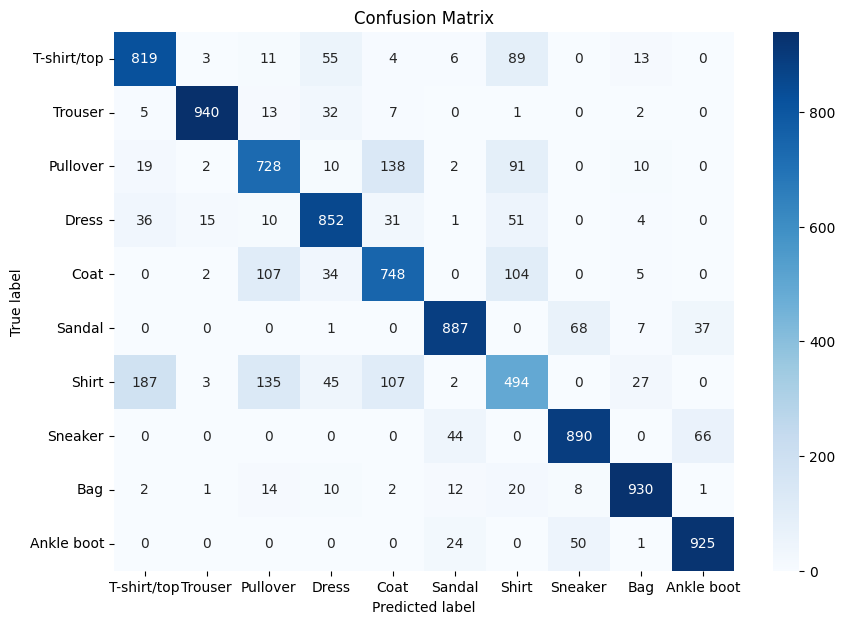

In [64]:
results = {}
table = []

test_loss, test_acc = 0, 0
for neuron_count in hidden_layer_neuron_counts:
    mlp = MLP(Model(neuron_count, do_rate=0.4), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=15)
    table += [
        [f'Train-{neuron_count}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{neuron_count}', format(test_acc), format(test_loss)]
    ]
    results[neuron_count] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }
    print('confusion_matrix for neuron count:', neuron_count)
    cm = plot_confusion_matrix(mlp.all_labels, mlp.all_preds, class_names)

In [65]:
print(tabulate(table, headers=["Neuron Count Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+-----------------------+----------+-------+
| Neuron Count Analysis | Accuracy | Loss  |
+-----------------------+----------+-------+
|       Train-32        |  0.782   | 0.620 |
|        Test-32        |  0.811   | 0.524 |
|       Train-64        |  0.809   | 0.549 |
|        Test-64        |  0.819   | 0.501 |
|       Train-128       |  0.820   | 0.513 |
|       Test-128        |  0.821   | 0.493 |
+-----------------------+----------+-------+


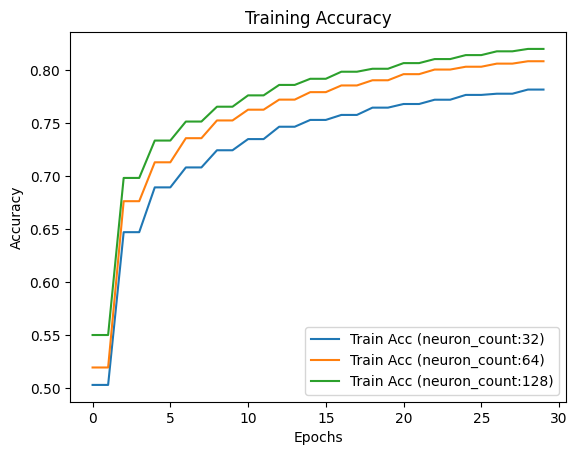

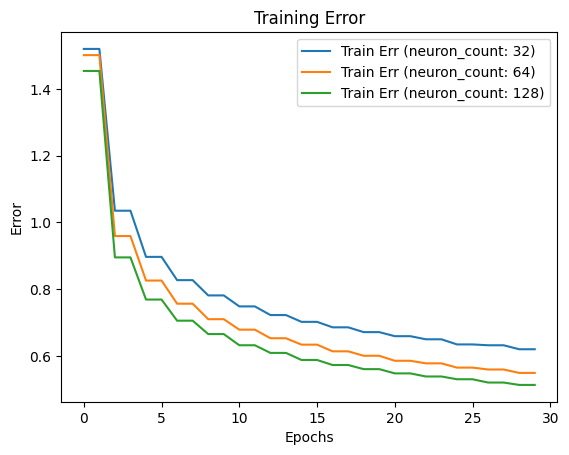

In [66]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (neuron_count:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (neuron_count: ', 
            y_label='Error', title='Training Error')

#### Learning Rate Analysis

confusion_matrix for learning rate: 0.001


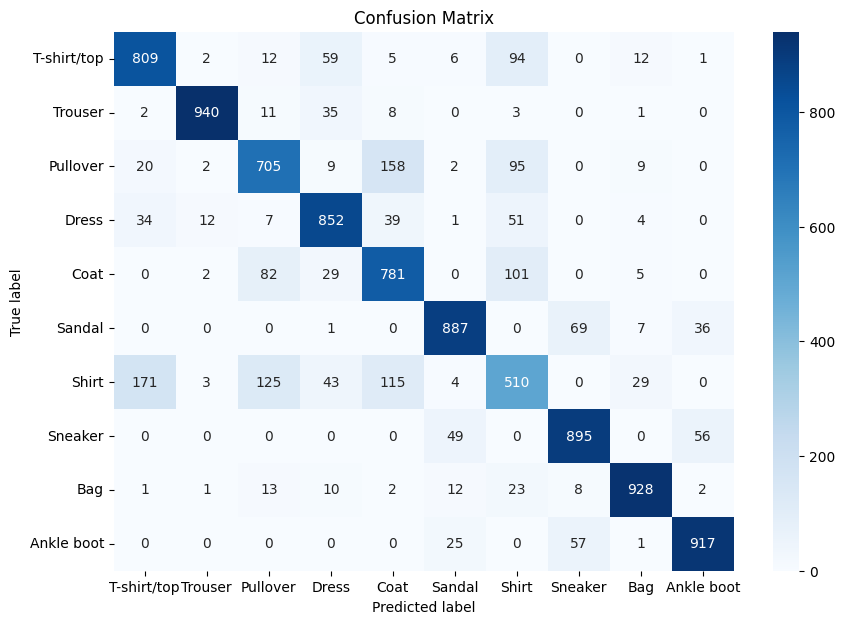

confusion_matrix for learning rate: 0.01


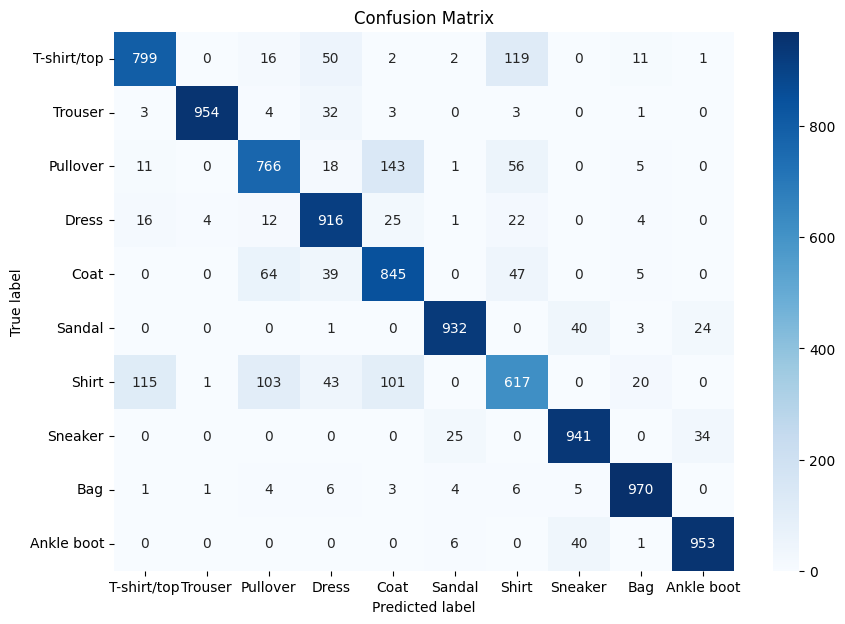

confusion_matrix for learning rate: 0.1


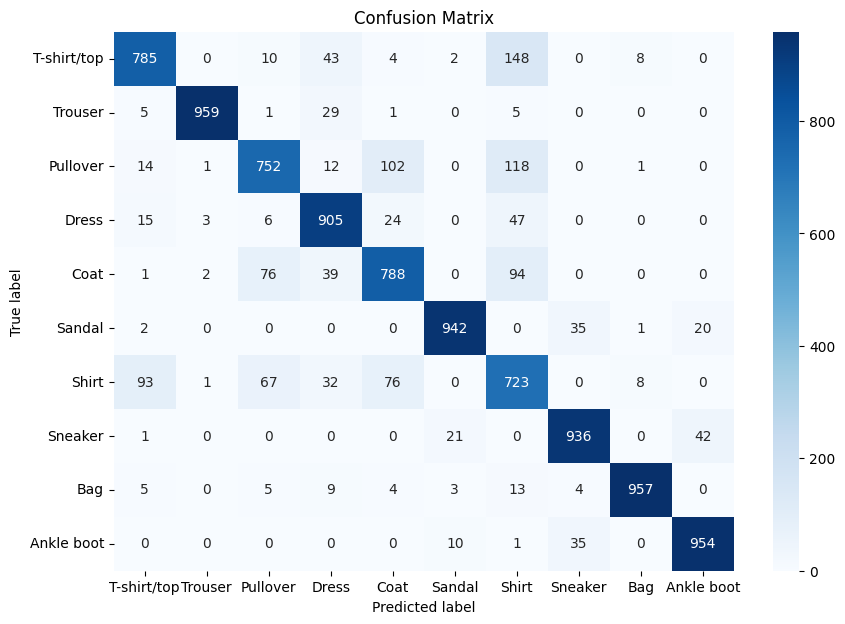

In [67]:
results = {}
table = []

test_loss, test_acc = 0, 0
for lr in learning_rates:
    mlp = MLP(Model(128, do_rate=0.4), nn.CrossEntropyLoss(), learning_rate=lr)
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=15)
    table += [
        [f'Train-{lr}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{lr}', format(test_acc), format(test_loss)]
    ]
    results[lr] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }
    print('confusion_matrix for learning rate:', lr)
    cm = plot_confusion_matrix(mlp.all_labels, mlp.all_preds, class_names)

In [68]:
print(tabulate(table, headers=["Learning Rate Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+------------------------+----------+-------+
| Learning Rate Analysis | Accuracy | Loss  |
+------------------------+----------+-------+
|      Train-0.001       |  0.820   | 0.512 |
|       Test-0.001       |  0.822   | 0.491 |
|       Train-0.01       |  0.876   | 0.350 |
|       Test-0.01        |  0.869   | 0.362 |
|       Train-0.1        |  0.875   | 0.338 |
|        Test-0.1        |  0.870   | 0.363 |
+------------------------+----------+-------+


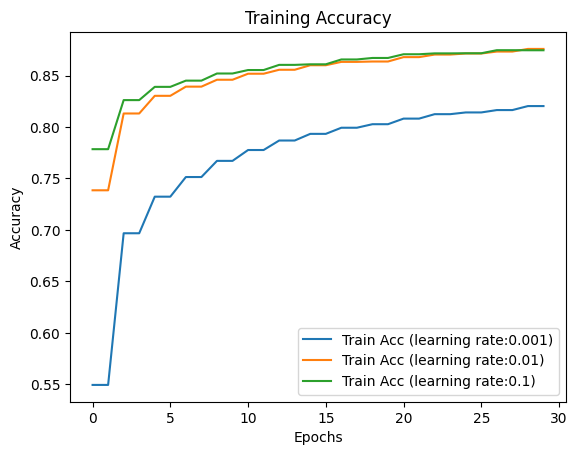

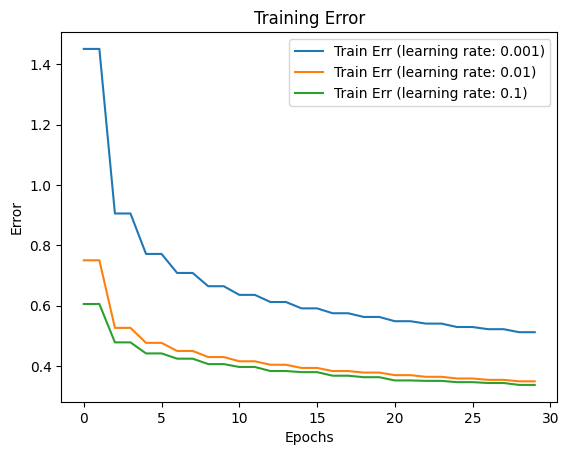

In [69]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (learning rate:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (learning rate: ', 
            y_label='Error', title='Training Error')

#### Bayesian Search

In [143]:
X_train = []
y_train = []

for images, labels in train_loader:
    X_train.append(images.view(images.size(0), -1))  # Flatten images to 1D
    y_train.append(labels)

X_train = torch.cat(X_train).numpy() 
y_train = torch.cat(y_train).numpy() 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skopt import BayesSearchCV
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split

class MLPWrapper(NeuralNetClassifier):
    def __init__(self, *args, criterion=nn.CrossEntropyLoss, **kwargs):
        super(MLPWrapper, self).__init__(*args, criterion=criterion, **kwargs)

param_space = {
    'module__h1': (64, 256),         # Hidden layer size
    'module__do_rate': (0.0, 0.5),   # Dropout rate
    'lr': (1e-4, 1e-2, 'log-uniform'),  # Learning rate in log scale
    'max_epochs': (10, 50)           # Number of epochs
}

model = MLPWrapper(
    module=Model,
    optimizer=optim.Adam,
    batch_size=64,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

bayes_search = BayesSearchCV(
    model,
    param_space,
    n_iter=20,  # Number of search iterations
    cv=3,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

print("Best parameters found: ", bayes_search.best_params_)
print("Best validation accuracy: ", bayes_search.best_score_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6087       0.8367        0.4449  2.1311
      2        0.4490       0.8539        0.4086  1.8831
      3        0.4135       0.8621        0.3776  1.8444
      4        0.3865       0.8670        0.3658  1.8431
      5        0.3679       0.8714        0.3476  1.8996
      6        0.3559       0.8713        0.3505  1.9028
      7        0.3457       0.8714        0.3476  1.9936
      8        0.3345       0.8767        0.3378  1.7307
      9        0.3254       0.8802        0.3264  1.7460
     10        0.3168       0.8829        0.3219  1.6619
     11        0.3097       0.8829        0.3237  1.6602
     12        0.3041       0.8872        0.3125  1.7160
     13        0.2990       0.8882        0.3129  1.6436
     14        0.2918       0.8882        0.3089  1.7140
     15        0.2852       0.8857        0.3172  1.6953
     16        0.2827       0.8

<!--  -->